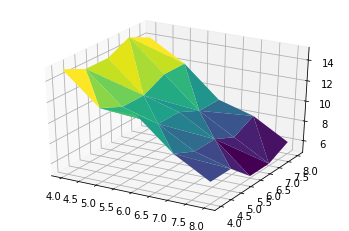

    Ind  Cashiers  Servers  Ushers  Wait
1     1         4        4       4    15
4     4         4        5       4    14
7     7         4        6       4    14
10   10         4        7       4    15
13   13         4        8       4    14
16   16         5        4       4    12
19   19         5        5       4    11
22   22         5        6       4    11
25   25         5        7       4    12
28   28         5        8       4    12
31   31         6        4       4    12
34   34         6        5       4    10
37   37         6        6       4    10
40   40         6        7       4     9
43   43         6        8       4     9
46   46         7        4       4     9
49   49         7        5       4     8
52   52         7        6       4     8
55   55         7        7       4     7
58   58         7        8       4     8
61   61         8        4       4     7
64   64         8        5       4     7
67   67         8        6       4     5
70   70         

In [8]:
import simpy
import random
import statistics
wait_times = []
simul_scan = {}


class Theater(object):
    def __init__(self, env, num_cashiers, num_servers, num_ushers):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)
        self.server = simpy.Resource(env, num_servers)
        self.usher = simpy.Resource(env, num_ushers)


        # More to come!

    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(random.randint(1, 3))

    def check_ticket(self, moviegoer):
        yield self.env.timeout(3 / 60)

    def sell_food(self, moviegoer):
        yield self.env.timeout(random.randint(1, 5))

        
def go_to_movies(env, moviegoer, theater):
    # Moviegoer arrives at the theater
    arrival_time = env.now

    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))

    with theater.usher.request() as request:
        yield request
        yield env.process(theater.check_ticket(moviegoer))

    if random.choice([True, False]):
        with theater.server.request() as request:
            yield request
            yield env.process(theater.sell_food(moviegoer))

    # Moviegoer heads into the theater
    wait_times.append(env.now - arrival_time)

    
def run_theater(env, num_cashiers, num_servers, num_ushers):
    theater = Theater(env, num_cashiers, num_servers, num_ushers)

    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater))

    while True:
        yield env.timeout(0.20)  # Wait a bit before generating a new person

        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))


def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)


def get_wait():
    global wait_times
    average_wait = statistics.mean(wait_times)
    wait_times = []
    return average_wait

    
def calculate_wait_time(arrival_times, departure_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)


def get_user_input():
    num_cashiers = input("Input # of cashiers working: ")
    num_servers = input("Input # of servers working: ")
    num_ushers = input("Input # of ushers working: ")
    params = [num_cashiers, num_servers, num_ushers]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Could not parse input. The simulation will use default values:",
            "\n1 cashier, 1 server, 1 usher.",
        )
        params = [1, 1, 1]
    return params

def main():
  # Setup
  random.seed(42)
  num_cashiers, num_servers, num_ushers = get_user_input()

  # Run the simulation
  env = simpy.Environment()
  env.process(run_theater(env, num_cashiers, num_servers, num_ushers))
  env.run(until=90)

  # View the results
  mins, secs = get_average_wait_time(wait_times)
  print(
      "Running simulation...",
      f"\nThe average wait time is {mins} minutes and {secs} seconds.",
  )


def plot(simul):
    import seaborn as sns
    sns.set_style="whitegrid"

    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    g = sns.relplot(
        data=simul,
        x="Cashiers", y="Servers",
        hue="Ushers", size="Wait").set(xlim=(0,5),ylim=(0,5))
    
    #g.set(xscale="log", yscale="log")
    #g.ax.xaxis.grid(True, "minor", linewidth=.25)
    #.ax.yaxis.grid(True, "minor", linewidth=.25)
    g.despine(left=True, bottom=True)    


def splot(df):
    import seaborn as sns
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    sns.set_style="whitegrid"

    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['Cashiers'], df['Servers'], df['Wait'], cmap=plt.cm.viridis, linewidth=0.2)
    plt.show()
    
def scan():
    import pandas as pd


    random.seed(42)
    #num_cashiers, num_servers, num_ushers = range(2,4), range(2,4), range(2,4)
    num_cashiers, num_servers, num_ushers = range(4, 9), range(4, 9), range(3, 6)

    # Run the simulation
    env = simpy.Environment()
    line = 0
    procs = []
    for cas in num_cashiers:
        for ser in num_servers:
            for ush in num_ushers:
                  
                  env = simpy.Environment()
                  env.process(run_theater(env, cas, ser, ush))
                  env.run(until=90)
                  procs.append((line, cas, ser, ush, int(get_wait()//2)))
                  line += 1
    simul = pd.DataFrame(procs, columns=["Ind", 'Cashiers', 'Servers', 'Ushers', "Wait"])
    simul = simul[simul['Ushers'] == 4]
    splot(simul)
    print(simul) 


#main()
scan()